In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Reading in proxy statements for Walmart from 2010 through 2019, reading each page of each PDF document as a separate row in the dataframe.

In [2]:
df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):

    pdfReader = PyPDF2.PdfFileReader("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Walmart/20%s_proxy.pdf"%(k))
    
    year = "20%s"%(k)
    company = 'Walmart'
    
    NumPages = pdfReader.getNumPages()
    
    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for i in range(1, NumPages):
        pageObj = pdfReader.getPage(i)
        page = pageObj.extractText()
        page = page.replace('\n \n',', ')
        page = page.replace('\n','')
        page = page.replace('\d+', '')
        sub_df = sub_df.append({'raw_text':page,'year':year,'company':company},ignore_index=True)
        
    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(966, 3)

In [92]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x) 
                                                   if word not in stop_words and word not in punctuations])

In [94]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])

In [174]:
remove_words =['shareholders™','walmart','board','mr.','ms.','director','walton','committee','proxy','meeting','share',
               'vote','shareholder','plan','inc.','http','stock']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [175]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [176]:
walmart_df = df[['year','company','tokens_final']]

walmart_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\walmart.csv', 
                 index = False)

In [177]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [178]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [179]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.022*"proposal" + 0.016*"executive" + 0.014*"office" + '
        '0.013*"report" + 0.012*"ownership" + 0.010*"holding" + 0.010*"option" '
        '+ 0.009*"mean" + 0.009*"number" + 0.008*"person"'),
    (   1,
        '0.031*"relationship" + 0.017*"year" + 0.016*"entity" + 0.016*"family" '
        '+ 0.014*"independence" + 0.014*"member" + 0.012*"entity™s" + '
        '0.010*"person" + 0.010*"director™s" + 0.009*"transaction"'),
    (   2,
        '0.042*"cash" + 0.037*"incentive" + 0.035*"target" + 0.032*"base" + '
        '0.027*"goal" + 0.026*"defer" + 0.022*"year" + 0.021*"amount" + '
        '0.015*"interest" + 0.014*"account"'),
    (   3,
        '0.034*"hold" + 0.029*"instruction" + 0.023*"record" + 0.021*"card" + '
        '0.020*"broker" + 0.019*"proposal" + 0.018*"holder" + 0.017*"name" + '
        '0.015*"receive" + 0.015*"bank"'),
    (   4,
        '0.021*"executive" + 0.020*"incentive" + 0.018*"ownership" + '
        '0.014*"time" + 0.014*"program" +

In [180]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [181]:
# pyLDAvis.show(vis)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.079959 -0.109730       1        1  27.365419
10    -0.199438  0.084809       2        1  14.689424
14    -0.169986  0.013918       3        1  11.952772
2     -0.166265  0.159585       4        1   7.869307
3      0.000666 -0.198359       5        1   6.719567
12    -0.040372 -0.151857       6        1   6.650668
4     -0.096282  0.043285       7        1   5.282391
7      0.075926 -0.152058       8        1   5.089211
11    -0.055351  0.020404       9        1   4.326582
1     -0.001631 -0.047658      10        1   4.303467
13     0.169485  0.012519      11        1   1.829682
8      0.163837  0.098446      12        1   1.033743
0      0.082140  0.075864      13        1   1.010935
6      0.147375  0.102157      14        1   0.943416
5      0.169854  0.048673      15        1   0.933415, topic_info=            Term        Freq       Total Category  logprob  loglift
4803       audit  929.000000  929.000000  Default  30.0000  30.0000
4940      member  981.000000  981.000000  Default  29.0000  29.0000
4780    proposal  602.000000  602.000000  Default  28.0000  28.0000
4986  experience  433.000000  433.000000  Default  27.0000  27.0000
1097      target  549.000000  549.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
4753    business    5.494911  785.638550  Topic15  -5.3391  -0.2886
4810  governance    3.898338  604.810730  Topic15  -5.6824  -0.3703
4836  compliance    3.402325  351.420624  Topic15  -5.8185   0.0366
4906        cngc    3.213812  398.894501  Topic15  -5.8755  -0.1472
7006   walmart™s    3.139637  260.006744  Topic15  -5.8989   0.2575

[1075 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
1626     14  0.494143                                 ,audit-relatedfees
5680      9  0.677054                                             ,james
1507     15  0.495815  ,ofallperformancesharesthatwouldhavevestedupon...
1509     15  0.494280  ,ofallunvestedrestrictedstockthatwouldhavevest...
1534     13  0.517555  ,sharesthatmaybeissueduponthevestingofperforma...
...     ...       ...                                                ...
7827      9  0.063149                                        ﬁinvestorsﬂ
8189      6  0.848638                                            ﬁpcaobﬂ
7801      3  0.065335                                            ﬁstreet
7801      5  0.882027                                            ﬁstreet
7817      5  0.840156                                             ﬁvotes

[3713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 11, 15, 3, 4, 13, 5, 8, 12, 2, 14, 9, 1, 7, 6])

In [182]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [183]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,NaN,NaN,10.0,0.9759,"unit, amount, value, column, grant, award, equ..."
1,2010,"[wal-martstores, www.walmartstores.comproxysta...",1.0,0.5546,"relationship, year, entity, family, independen..."
2,2010,"[fiscalnonqualifieddeferredcompensation, ..hol...",1.0,0.9797,"relationship, year, entity, family, independen..."
3,2010,"[directorcompensationplan, thewal-martstores, ...",3.0,0.9787,"hold, instruction, record, card, broker, propo..."
4,2010,"[whatamivotingon, youarevotingon, •theapproval...",7.0,0.8931,"audit, member, transaction, service, accountan..."
5,2010,"[brokernon-vote, ontheproposalstobevotedonatth...",14.0,0.7113,"sale, material, income, measure, currency, cal..."
6,2010,[scorporatesecretaryattheaddressonthefrontcove...,8.0,0.9836,"group, equity, target, investment, chairman, s..."
7,2010,"[youwillbeadmittedtotheannualshareholders, bro...",3.0,0.6427,"hold, instruction, record, card, broker, propo..."
8,2010,"[m.micheleburns, asubsidiaryofmarsh, mclennanc...",14.0,0.9539,"sale, material, income, measure, currency, cal..."
9,2010,"[michaelt.duke, .priortothisappointment, hehel...",8.0,0.9783,"group, equity, target, investment, chairman, s..."


In [184]:
df_dominant_topic.shape

(965, 5)

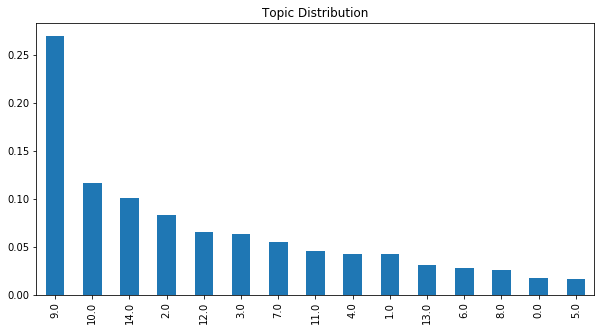

In [185]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [186]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [187]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.031915,0.063830,0.053191,0.053191,0.010638,0.074468,0.106383,0.063830,0.148936,0.053191,0.063830,0.074468,0.063830,0.074468,0.063830
2011,0.047619,0.079365,0.047619,0.079365,0.047619,0.015873,0.111111,0.095238,0.095238,0.031746,0.031746,0.111111,0.015873,0.142857,0.047619
2012,0.030303,0.090909,0.090909,0.030303,0.030303,0.060606,0.121212,0.136364,0.060606,0.090909,0.000000,0.090909,0.045455,0.075758,0.045455
2013,0.038961,0.038961,0.129870,0.064935,0.064935,0.000000,0.000000,0.064935,0.000000,0.259740,0.142857,0.064935,0.064935,0.025974,0.038961
2014,0.021739,0.043478,0.086957,0.065217,0.065217,0.010870,0.010870,0.043478,0.000000,0.260870,0.152174,0.021739,0.108696,0.032609,0.076087
2015,0.000000,0.042373,0.067797,0.059322,0.042373,0.000000,0.000000,0.033898,0.000000,0.288136,0.127119,0.042373,0.050847,0.016949,0.228814
2016,0.009434,0.018868,0.084906,0.056604,0.047170,0.000000,0.000000,0.028302,0.000000,0.339623,0.169811,0.028302,0.066038,0.000000,0.150943
2017,0.008850,0.026549,0.088496,0.070796,0.035398,0.000000,0.000000,0.044248,0.000000,0.424779,0.141593,0.017699,0.061947,0.000000,0.079646
2018,0.009346,0.018692,0.084112,0.056075,0.037383,0.000000,0.000000,0.046729,0.000000,0.401869,0.149533,0.028037,0.084112,0.000000,0.084112


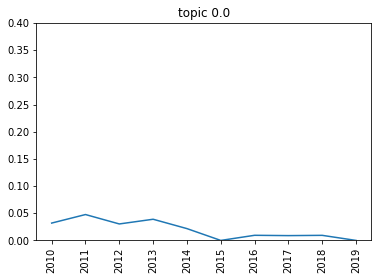

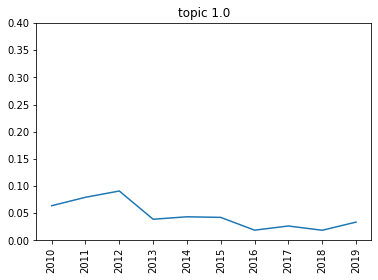

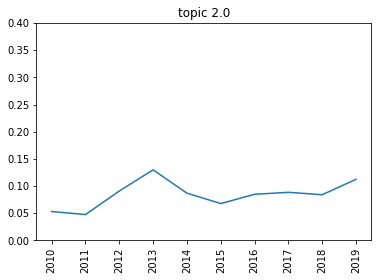

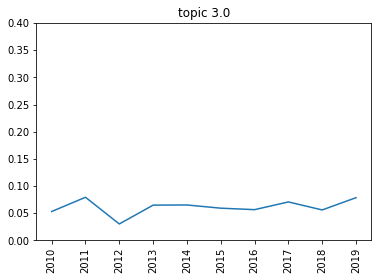

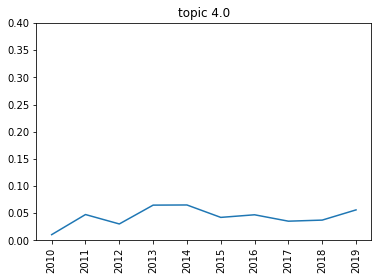

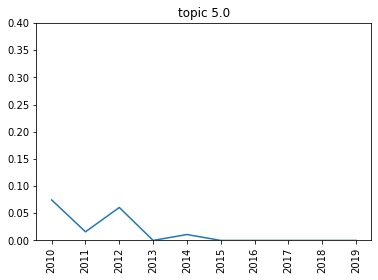

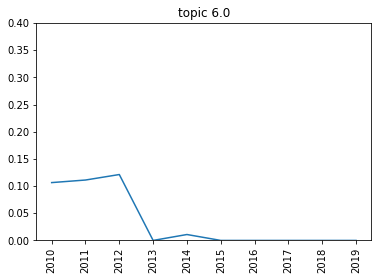

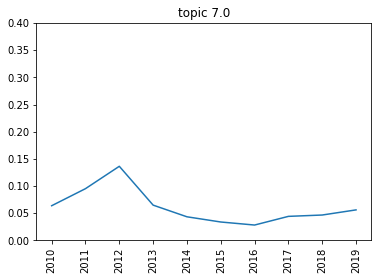

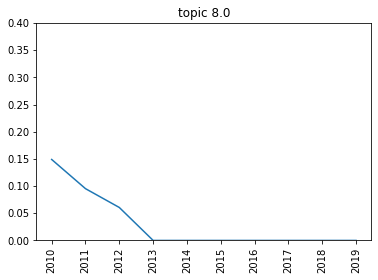

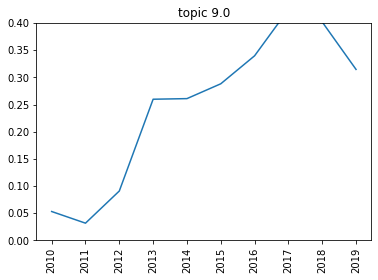

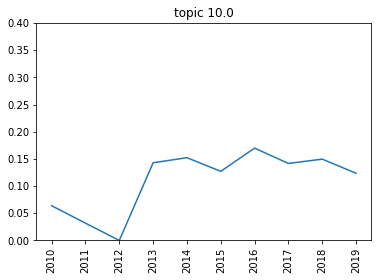

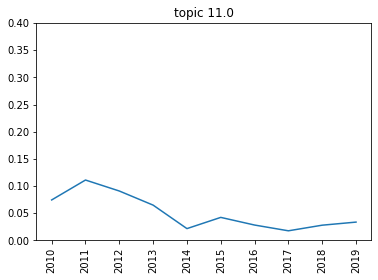

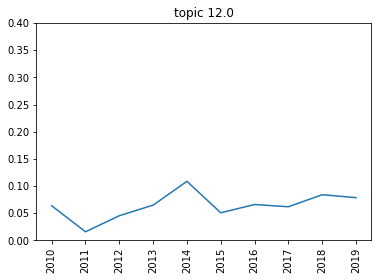

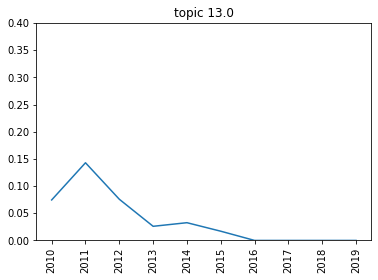

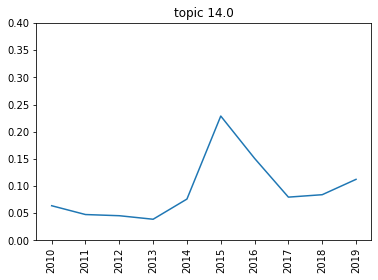

In [188]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

### Checking for correlation with CPI 

Data is Consumer Price Index for all items less medical care in the US

In [189]:
df_cpi = pd.read_csv('CPI.csv')
df_cpi.columns = ['date','cpi']

In [190]:
df_trend = df_trend.reset_index()
df_trend_new = df_trend.drop('year', axis=1)

In [191]:
df_trend_new.corrwith(df_cpi['cpi'])

topic
0.0     0.489935
1.0     0.280279
2.0    -0.150675
3.0     0.222464
4.0    -0.072780
5.0     0.120459
6.0     0.421521
7.0     0.482631
8.0     0.316255
9.0    -0.239035
10.0   -0.392122
11.0    0.366005
12.0   -0.229404
13.0    0.478669
14.0   -0.761113
dtype: float64

### Checking for correlation with Labor Force Statistics/Unemployment Rate

In [192]:
labor = pd.read_excel('LaborForceStats.xlsx')

In [193]:
labor['avg'] = labor[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].mean(axis=1)
labor

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg
0,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3,9.608333
1,2011,9.1,9.0,9.0,9.1,9.0,9.1,9.0,9.0,9.0,8.8,8.6,8.5,8.933333
2,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9,8.075000
3,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7,7.358333
4,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6,6.158333
5,2015,5.7,5.5,5.4,5.4,5.6,5.3,5.2,5.1,5.0,5.0,5.1,5.0,5.275000
6,2016,4.9,4.9,5.0,5.0,4.8,4.9,4.8,4.9,5.0,4.9,4.7,4.7,4.875000
7,2017,4.7,4.6,4.4,4.4,4.4,4.3,4.3,4.4,4.2,4.1,4.2,4.1,4.341667
8,2018,4.1,4.1,4.0,4.0,3.8,4.0,3.8,3.8,3.7,3.8,3.7,3.9,3.891667
9,2019,4.0,3.8,3.8,3.6,3.6,3.7,3.7,3.7,3.5,3.6,3.5,3.5,3.666667


In [194]:
df_trend_new.corrwith(labor['avg'])

topic
0.0     0.880692
1.0     0.828078
2.0    -0.427664
3.0    -0.267465
4.0    -0.336763
5.0     0.755201
6.0     0.846907
7.0     0.626529
8.0     0.846683
9.0    -0.931619
10.0   -0.735414
11.0    0.854184
12.0   -0.498384
13.0    0.864550
14.0   -0.511860
dtype: float64

### Checking for correlation with WMT Stock Price

In [195]:
stocks = pd.read_csv('WMT.csv')

In [196]:
from datetime import datetime as dt

stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.sort_values(by='Date',ascending=True)

In [197]:
stocks['Year'] = stocks['Date'].dt.year

In [198]:
stocks_new = stocks.groupby('Year')[['Close','Adj Close']].mean().reset_index()
stocks_new

,Year,Close,Adj Close
0,2010,52.700833,41.329478
1,2011,54.718333,43.993219
2,2012,67.682500,55.885999
3,2013,75.328333,63.681703
4,2014,77.716666,67.334563
5,2015,71.111667,63.070783
6,2016,69.830000,63.833105
7,2017,79.891666,75.149879
8,2018,92.692501,89.256581
9,2019,108.802499,107.159365


In [199]:
df_trend_new.corrwith(stocks_new['Adj Close'])

topic
0.0    -0.716899
1.0    -0.648463
2.0     0.598421
3.0     0.318101
4.0     0.382728
5.0    -0.596932
6.0    -0.692002
7.0    -0.372614
8.0    -0.705975
9.0     0.747795
10.0    0.540398
11.0   -0.672605
12.0    0.545910
13.0   -0.737155
14.0    0.215845
dtype: float64